In [1]:
from xml.dom import minidom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

# Extracting and claning the data

I'm using the minidom module to read in the data in the xml file.

In [2]:
f = minidom.parse('export.xml')
itemlist = f.getElementsByTagName('Record')

I want to put the data into a data frame so I start by creating an empty dictionary where each key is the to-be column in the data frame.

In [3]:
obj = {}

obj['record_type'] = []
obj['value'] = []
obj['creation_date'] = []

Next, I fill in the dictionary values.

In [4]:
for item in itemlist:
    obj['record_type'].append(item.attributes['type'].value.replace('HKQuantityTypeIdentifier', ''))
    obj['value'].append(item.attributes['value'].value)
    obj['creation_date'].append(item.attributes['creationDate'].value)

And now I can use the dictionary to create a data frame.

In [5]:
df = pd.DataFrame(obj)
df.head()

,record_type,value,creation_date
0,StepCount,14,2016-07-10 11:04:05 +0300
1,StepCount,47,2016-07-10 12:05:18 +0300
2,StepCount,177,2016-07-10 12:05:18 +0300
3,StepCount,347,2016-07-10 12:05:18 +0300
4,StepCount,524,2016-07-10 12:05:18 +0300


Correcting the data types.

In [6]:
df = df.astype({"value": float})
df['creation_date'] = pd.to_datetime(df['creation_date'].str[:-6])
df['creation_dt'] = df['creation_date'].dt.to_period('D').dt.to_timestamp()

I'm only interested in the "FlightsClimbed" data for the first 5 months of 2019, so I'm only keeping those rows.

In [7]:
df = df[(df['record_type'] == 'FlightsClimbed') & 
        (df['creation_dt'] > '2018-12-31') & 
        (df['creation_dt'] < '2019-06-01')]

Then I group the data by date because I want only one data row per day.

In [8]:
df = df.groupby(['creation_dt'])[['value']].sum()
df = df.rename(columns={"value": "steps"})
df.head()

,steps
creation_dt,
2019-01-01,5.0
2019-01-02,47.0
2019-01-03,25.0
2019-01-04,29.0
2019-01-05,6.0


Last but not least, I convert the number of steps into meters and also add cumulative steps amount. According to Apple, a flight of stairs is approximately 10 feet which is 3.048 meters.

In [9]:
df['steps_m'] = df['steps']*3.048
df['cum_steps'] = df['steps'].cumsum()
df['cum_steps_m'] = df['cum_steps']*3.048
df.head()

,steps,steps_m,cum_steps,cum_steps_m
creation_dt,,,,
2019-01-01,5.0,15.240,5.0,15.240
2019-01-02,47.0,143.256,52.0,158.496
2019-01-03,25.0,76.200,77.0,234.696
2019-01-04,29.0,88.392,106.0,323.088
2019-01-05,6.0,18.288,112.0,341.376


# Visualization

First, let's see what has been the distribution of steps by day over this 5 month period.

In [10]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

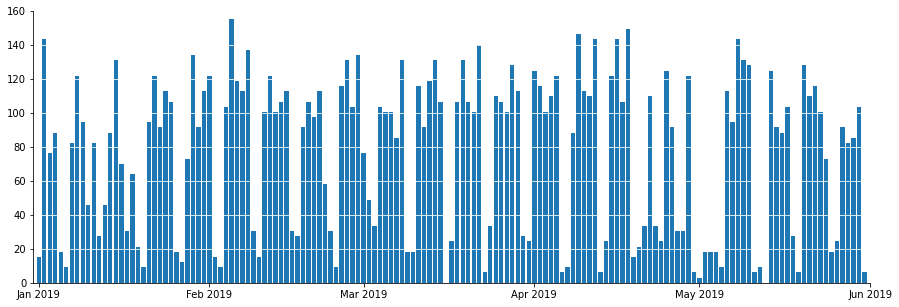

In [11]:
fig,ax = plt.subplots(figsize = (15, 5))

months = mdates.MonthLocator()
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xlim([datetime.date(2018, 12, 31), datetime.date(2019, 6, 1)])
plt.ylim(0,160)

plt.grid(b=None, which='major', axis='y', linestyle='-', color='#FFFFFF')

plt.bar(df.index, df['steps_m'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig('flights_climbed_timeline.png', dpi=200, bbox_inches='tight')

plt.show()

Then let's see the cumulative progress of flights climbed in meters. For comparison, I add some milestones to compare the progress.

For the milestones, I first create a dictionary with their names and the actual hight. I then create two more empty dictionaries, one for the date when I passed the milestone and the other for the flights climbed in meters for the day I passed the milestone.

In [12]:
milestones = {'Burj Khalifa': 828, 'Mont Blanc':4810, 'Mount Kilimanjaro': 5895, 
              'Mount Everest': 8848, 'Commercial airplane altitude':10600}
milestones_dates = {}
milestones_values = {}

And then I fill in the two empty dictionaries with the corresponding data.

In [13]:
for milestone in milestones:
    for i, timestamp in enumerate(df.index):
        if df['cum_steps_m'][i] < milestones[milestone]:
            pass
        else:
            milestones_dates[milestone] = timestamp
            milestones_values[milestone] = df['cum_steps_m'][i]
            break

And lastly, I'm able to put all that into another data frame.

In [14]:
data = [milestones, milestones_values, milestones_dates] 
df_milestones = pd.DataFrame(data, index =['value', 'date_value', 'date'])
df_milestones = df_milestones.transpose()
df_milestones.head()

,value,date_value,date
Burj Khalifa,828,850.392,2019-01-13
Mont Blanc,4810,4907.28,2019-03-04
Mount Kilimanjaro,5895,5925.31,2019-03-15
Mount Everest,8848,8924.54,2019-04-18
Commercial airplane altitude,10600,10668,2019-05-17


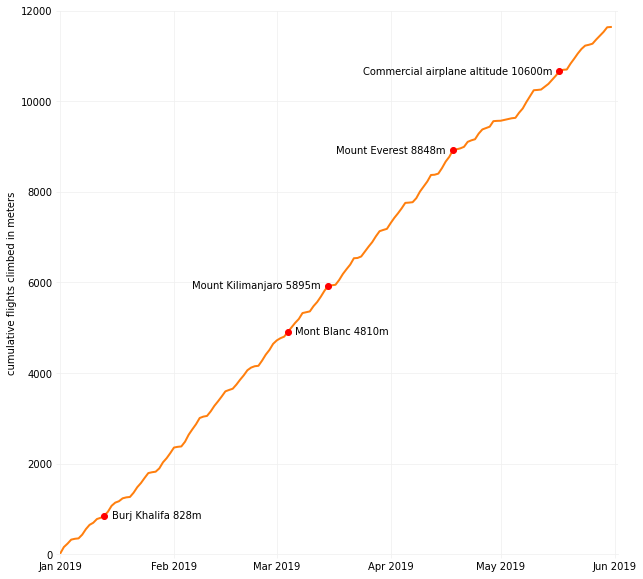

In [15]:
fig,ax = plt.subplots(figsize = (10, 10))

# tweak axes and gridlines
plt.gca().xaxis.set_major_locator(months)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xlim([datetime.date(2019, 1, 1), datetime.date(2019, 6, 2)])
plt.ylim(-1, 12000)
plt.grid(which='major', color='#F0F0F0', axis='both')

# plot cumulative steps and milestones
plt.plot(df.index, df['cum_steps_m'], color='#ff7f0e', linewidth=2)
plt.scatter(df_milestones['date'], df_milestones['date_value'], color='red', zorder=99)

# add milestone labels
for i, index in enumerate(df_milestones.index):
    if i <= 1:
        plt.text(x=df_milestones['date'][i] + pd.DateOffset(2),
                 y=df_milestones['date_value'][i], 
                 s=index+" "+str(df_milestones['value'][i])+"m", 
                 ha='left',
                 va='center')
    else:
        plt.text(x=df_milestones['date'][i] + pd.DateOffset(-2),
                 y=df_milestones['date_value'][i], 
                 s=index+" "+str(df_milestones['value'][i])+"m", 
                 ha='right',
                 va='center')

# some more tweaks
ax.tick_params(axis=u'both', which=u'both',length=4, color='#F0F0F0')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('#F0F0F0')
ax.spines['left'].set_visible(False)
ax.set_ylabel('cumulative flights climbed in meters')

# plt.savefig('flights_climbed_progress.png', dpi=200, bbox_inches='tight')

plt.show()